# This Cat Does Not Exist with Wasserstein GAN

In this assignment, you'll implement a specialized GAN architecture: the Wasserstein GAN (WGAN) to generate images of cats! Similar to [This person does not exist.com](https://thispersondoesnotexist.com/), you will create a "This cat does not exist" using a WGAN. The paper introducing WGANs contains all the depth about them, which you can read if interested: 
[Wasserstein Generative Adversarial Networks](https://proceedings.mlr.press/v70/arjovsky17a.html)

In short, the main differences between a standard GAN and WGAN are:
- Loss Function: Standard GANs use a binary cross-entropy loss, which can lead to issues like vanishing gradients. WGANs use the Wasserstein loss, which provides a more informative gradient for training.

- Output Range: In standard GANs, the discriminator outputs values typically constrained between 0 and 1, representing the probability that an image is real. In WGANs, the critic outputs real-valued scores, allowing for a broader range of predictions

- Training Frequency: In WGANs, the critic is often trained more frequently than the generator, typically several iterations per generator update. This allows the critic to provide more accurate feedback to the generator, enhancing the overall training stability and quality of the generated images.

- Training Stability: WGANs generally exhibit more stable training behavior compared to standard GANs. The Wasserstein loss helps mitigate common problems like mode collapse and exploding/vanishing gradient

The notebook has several TODOs for you to complete. This notebook can be run in Google Colab, Kaggle, locally, or any other framework. Note that the training loop for the network will likely take very long if you do not have a GPU locally, so it is recommended to run this on Colab/Kaggle and utilize their free T4 GPUs. 

Be sure to answer the discussion questions at the very end.

In [4]:
import torch
import torchvision
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
# tqdm is a library helps visualize progress in any loop; it will be helpful for us and our sanity during the training loop
from tqdm.auto import tqdm

### 1. Downloading Data
We'll be using the [Cat faces data set](https://github.com/fferlito/Cat-faces-dataset) with about 30,000 pictures of cat faces, available on Github.  This is a superset of the smaller 10,000 [Cat face dataset on Kaggle](https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models).  If you are resource-constrained, you may choose to use the 10k faces as it will still yield reasonable results.

Unfortunately, PyTorch does not offer the same level of download supporting utilities as keras and tensorflow, so there is no single callable function to download and uncompress all of the data.  Instead, you may either download the data directly from Github and copy into a single folder or use the provided function below to download the data.  Note that we will continue to see some of these comparisons between frameworks, in which they each have certain advantages.

In [5]:
# Download the data set
# This downloads into the folder path "./data/cat-faces" by default
import urllib.request
from pathlib import Path
import tarfile
import shutil

url_base='https://github.com/fferlito/Cat-faces-dataset/raw/refs/heads/master/dataset-part{}.tar.gz'

base_dir= Path('data')
data_dir = base_dir / 'cat-faces'
if not data_dir.exists():
    data_dir.mkdir(parents=True, exist_ok=True)
if not any(data_dir.iterdir()): # only download if data_dir empty
    for part in [1,2,3]:
        print("Processing part " + str(part))
        tar_path = base_dir / f'dataset-part{part}.tar.gz'
        urllib.request.urlretrieve(url_base.format(part), tar_path)
        with tarfile.open(tar_path, 'r:gz') as tar_ref: # unpack tar
            temp_extract_dir = base_dir / f'temp_part{part}'
            tar_ref.extractall(temp_extract_dir)
            for item in temp_extract_dir.rglob('*'): # move out of sub-directories into single data_dir
                if item.is_file():
                    target_path = data_dir / item.name
                    if target_path.exists():
                        target_path = data_dir / f'{item.stem}_{part}{item.suffix}'
                    shutil.move(str(item), str(target_path))
            shutil.rmtree(temp_extract_dir)
        tar_path.unlink()

In [6]:
# TODO: Depending on how you are running this notebook, you will have define the device
# Either 'cpu' (default machine CPU), 'cuda' (GPU (including T4)), 'mps' (M-series Macs) 
device = torch.device('cpu')
z_dim = 200  # Dimensionality of the latent space (input noise size)
batch_size = 128  
lr = 0.001

In [7]:
# Creates a grid of 25 images to display
def show(tensor, num=25, name=''):
    data = tensor.detach().cpu() #  Detaches the tensor from the computation graph and moves it to the CPU for visualization.
    grid = make_grid(data[:num], nrow=5).permute(1,2,0) # adjust dimensions to be suitable for plotting (height, weight, channels)
    plt.imshow(grid.clip(0,1))
    plt.show()

#### 2.a. The Generator
The Generator is responsible for generating images from random noise. It uses a series of transposed convolution layers to upscale the input noise vector into an image, then condense it down to 3 channels for an output image.

In [8]:
class Generator(nn.Module):
    # d_dim is the base depth dimension multiplier for the model, controlling the number of chanels
    def __init__(self, z_dim=64, d_dim=16):
        super(Generator, self).__init__()
        self.z_dim = z_dim 
        
        self.gen = nn.Sequential(
            # Define your own model architecture here!
            # 1. The first layer should be a ConvTranspose2d layer that takes a noise vector of size `z_dim` 
            #    and expands it to a larger number of channels. This layer should reshape the input from 
            #    a tensor to a larger spatial dimension. You can use d_dim * 32 or any suitable 
            #    scaling factor for the output channels.
            #
            # 2. After the first layer, use nn.BatchNorm2d to normalize the output and 
            #    nn.ReLU as the activation function to introduce non-linearity.
            #
            # 3. Continue adding ConvTranspose2d layers that progressively reduce the number of channels 
            #    by half (or any exponential reduction) until you reach the desired number of output channels 
            #    (which should be 3 channels for RGB images).
            #
            # 4. Ensure that the last layer is a ConvTranspose2d layer that outputs 3 channels 
            #    and applies the nn.Tanh activation function to scale the pixel values to the range [-1, 1].

            nn.ConvTranspose2d(in_channels=z_dim, out_channels=d_dim * 32, kernel_size=4, stride=1, padding=0), 
            nn.BatchNorm2d(d_dim * 32),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=d_dim * 32, out_channels=d_dim * 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(d_dim * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=d_dim * 16, out_channels=d_dim * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(d_dim * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=d_dim * 8, out_channels=d_dim * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(d_dim * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=d_dim * 4, out_channels=d_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(d_dim ),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=d_dim, out_channels=d_dim * 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    
    def forward(self, noise):
        # Reshape the input noise into a 4D tensor suitable for the generator (batch_size x z_dim x 1 x 1).
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

'''
num: Number of noise vectors to generate.
z_dim: Dimensionality of each noise vector.
device: Specifies where to generate the noise ('cuda' for GPU or 'cpu' for CPU).
'''
def gen_noise(num, z_dim, device=device):
    return torch.randn(num, z_dim, device=device)

#### 2.b. The Critic
The Critic in a WGAN is designed to estimate the Wasserstein distance between the distribution of real images and generated images. 

The architecture you will build provided for the Critic class will use several convolutional layers to achieve this. The output of the critic is a single scalar value representing the critic's score for the input image, which aligns with the WGAN's approach of providing continuous feedback rather than binary classification (real or fake). This ensures that small changes in the input lead to small changes in the output, which is fundamental for maintaining stability during training.


In [9]:
# Critic/ Descriminator
class Critic(nn.Module):
    def __init__(self,d_dim=16):
        super(Critic,self).__init__()
        
        self.crit = nn.Sequential(
            # TODO: Define your own model architecture here!
            # 1. The first layer should be a Conv2d layer that takes the input image from the generator or dataset (3 channels for RGB)
            #    and expands it to a larger number of channels. You can use d_dim as the base multiplier
            #    to control the number of output channels. For example, the first layer can output d_dim channels.
            #
            # 2. After the first Conv2d layer, use nn.InstanceNorm2d to normalize the output, which helps in stabilizing
            #    the training, and apply nn.LeakyReLU as the activation function to introduce non-linearity. 
            #    Set a negative slope (0 < x < 1) as a parameter for the for LeakyReLU to allow a small, non-zero gradient when the input is negative.
            #
            # 3. Continue adding Conv2d layers that progressively double the number of channels with each layer 
            #    until you reach the desired number of channels. For example, if you start with d_dim channels,
            #    the subsequent layers should output d_dim*2, d_dim*4, and so on.
            #
            # 4. Ensure that the final Conv2d layer outputs a single channel. This layer should downsample the 
            #    previous output to produce a single scalar value that represents the critic's prediction 
            #    (indicating whether the image is real or fake).
            #
            # Here’s a sample structure to get you started:
            #
            nn.Conv2d(in_channels=3, out_channels=d_dim, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(d_dim),
            nn.LeakyReLU(-0.25),
            
            nn.Conv2d(in_channels=d_dim, out_channels=d_dim * 2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(d_dim * 2),
            nn.LeakyReLU(-0.25),

            nn.Conv2d(in_channels=d_dim * 2, out_channels=d_dim * 4, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(d_dim * 4),
            nn.LeakyReLU(-0.25),

            nn.Conv2d(in_channels=d_dim * 4, out_channels=d_dim * 8, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(d_dim * 8),
            nn.LeakyReLU(-0.25),

            nn.Conv2d(in_channels=d_dim * 8, out_channels=d_dim * 16, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(d_dim * 16),
            nn.LeakyReLU(-0.25),

            nn.Conv2d(in_channels=d_dim * 16, out_channels=d_dim * 32, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(d_dim * 32),
            nn.LeakyReLU(-0.25),
            
            nn.Conv2d(d_dim * 32, z_dim, kernel_size=4, stride=1, padding=0), # Maybe 1 and not z_dim
            # This final layer will produce a single output scalar that indicates the critic's confidence.
        )

    def forward(self, image):
        crit_pred = self.crit(image)
        # Reshapes the output to (batch_size, 1), which is a 1D tensor of scores, where each score indicates the critic's confidence that the image is real or fake
        return crit_pred.view(len(crit_pred),-1)

### 3. Initialize Models and Data

This code sets up a dataset class for loading and processing images, initializes a DataLoader for batching, and prepares generator and critic models along with their optimizers for a GAN. The images are resized and normalized before being passed into the models for training or inference.

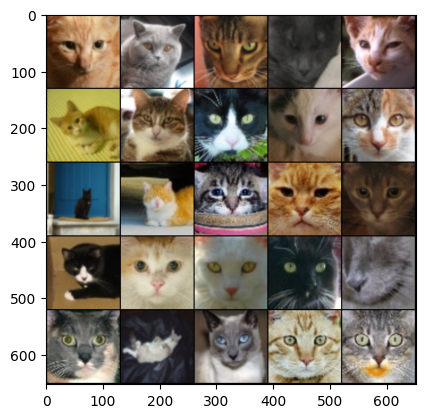

In [10]:
# Dataset, DataLoader, declare gen,crit, test dataset

class Dataset(Dataset):
    def __init__(self, path, size=128, lim=10000):
        self.sizes=[size, size]
        items, labels=[],[]

        # add image and file name to respective lists in dataset class
        for data in os.listdir(path)[:lim]:
            item = os.path.join(path,data)
            items.append(item)
            labels.append(data)
        self.items=items
        self.labels=labels

    def __len__(self):
        return len(self.items)

    def __getitem__(self,idx):
        data = PIL.Image.open(self.items[idx]).convert('RGB') # Opens the image and converts it to RGB format.
        data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # resizes image to 128 x 128 x 3 and convert to numpy array
        data = np.transpose(data, (2,0,1)).astype(np.float32, copy=False) # changes the shape of the image from (height, width, channels) to (channels, height, width) to match PyTorch’s tensor format.
        data = torch.from_numpy(data).div(255) # converts numpy array to Pytorch tensor and normalizes pixel values from [0, 255] to [0,1]
        return data, self.labels[idx]

# TODO: Fill out data path
data_path = './data/cat-faces'
ds = Dataset(data_path, size=128, lim=10000) # 128 x 128 images, 10,000 limit to load

# DataLoader
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

# TODO: Initialize gen and crit models and move them to specified device
gen = Generator().to(device)
crit = Critic().to(device)

# Optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5,0.9)) # betas are hyperparameters that control the exponential decay rates for the moment estimates, help with stability and convergence
crit_opt= torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5,0.9))

# Retrieves the next batch of images (x) and their corresponding labels (y) from the DataLoader
x,y=next(iter(dataloader))
# example training data
show(x)

#### 4. Calculating the gradient penalty for the WGAN 
The gradient penalty enforces the Lipschitz continuity condition required by WGANs, 
ensuring that the critic's function remains smooth and stable. Unlike traditional GANs, 
which constrain the critic's output to a specific range (usually binary [0, 1]), 
WGANs allow for real-valued outputs (scalar score's in our implementation), ultimately
providing more meaningful gradients to the generator.
This makes the gradient penalty crucial for maintaining stability and convergence during training.


In [11]:
'''
real: A batch of real images (tensor).
fake: A batch of generated (fake) images (tensor).
crit: The critic model (discriminator).
alpha: A mixing factor (between 0 and 1) used to create interpolated images.
gamma: A hyperparameter used to scale the gradient penalty (default is 10).
'''
def get_gradient_penalty(real, fake, crit, alpha, gamma=10):
    # Create a batch of mixed images by blending tensor representations for real and fake images
    # Mixed images should be the sum of scaling the real images by alpha and the fake images by (1-alpha) 
    mix_images = real * alpha + fake * (1 - alpha) # creates a batch of interpolated images by blending real and fake images of size 128 x 3 x 128 x 128
    mix_scores = crit(mix_images) # passed through critic to get their scores, size: 128 x 1

    gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs=torch.ones_like(mix_scores), # want to compute the gradients of mix_scores as if they were scaled by 1
      retain_graph=True,
      create_graph=True,
    )[0] # gradient has the same shape as mix_images, which is 128 x 3 x 128 x 128

    # The goal is to encourage the gradients to be close to 1 for all mixed images. 
    # If the gradient norm is 1, the critic is neither too sensitive nor too flat in its response to changes in the input
    gradient = gradient.view(len(gradient), -1)   # flattens gradient down to 128 x 49152 so that we can compute norm easier
    gradient_norm = gradient.norm(2, dim=1) # computes norm of each row, representing the size of the gradient for each image
    gp = gamma * ((gradient_norm-1)**2).mean() # calculates the gradient penalty, which penalizes the model if the L2 norm of the gradients deviates from 1

    return gp

### 5. The Training Loop
This code block implements the training loop for our WGAN with the gradient penalty. The critic is trained multiple times per generator update to stabilize training, aiming to correctly classify real and fake images, while the generator is updated to improve its ability to produce realistic images. Losses for both networks are calculated and backpropagated to update their weights, and the training progress is visualized periodically with generated and real images along with loss curves.


### Training loop will take a long time, and it is recommended to run using a T4 GPU on colab/kaggle if you do not have a GPU

In [13]:
# define training variables and hyperparameters    
n_epochs = 20  
current_step = 0  
crit_cycle = 5  # critic trains for 5 steps per generator step
gen_losses = []  
crit_losses = [] 
show_step = 35 

# Training Loop
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        current_batch_size= len(real) # get 128 real images
        real=real.to(device) # Move the real images to the specified device (CPU or GPU)

        
        mean_crit_loss = 0
        # You need to implement Critic training loop
        # Critic Training in WGANs typically involve multiple updates to the critic for each update to the generator
        # Critic trained multiple times per iteration to stabilize training, while the generator is updated based on the critic's feedback.
        for _ in range(crit_cycle):
            # TODO: clear gradients for critic's optimizer
            crit_opt.zero_grad()
            
            # TODO: create noise vectors for the generator input
            noise= torch.randn(current_batch_size, z_dim, 1, 1).to(device)
            # TODO:  # get fake images for noise vectors using generator 
            fake = gen(noise)
            # TODO: # get critic's prediction of fake images (remember to detach to avoid futher backpropagation to the generator)
            crit_fake_pred = crit(fake.detach())
            # TODO: get critic's prediction of real images
            crit_real_pred = crit(real)

            # TODO: generate alpha parameter for gradient penalty using torch.rand(), size should be 128 x 1 x 1 x 1, set requires_grad = True to signal PyTorch to keep track of gradients for this tensor
            alpha= None
            # TODO: calculate the gradient penalty, passing in alpha parameter (remember to detach fake images!)
            gp = get_gradient_penalty(real, fake.detach(), crit, alpha)

            '''
            Critic loss is derived from the Wasserstein distance
            It combines the mean predictions for fake and real images, plus the gradient penalty.
            The overall goal is to minimize crit_loss. This involves:
                - Maximizing crit_real_pred: Encouraging the critic to give higher scores to real images (ideally, close to 1).
                - Minimizing crit_fake_pred: Encouraging the critic to give lower scores to fake images (ideally, close to 0).
                - Balancing with gp: The gradient penalty term should be relatively small and ideally close to 0 to ensure stability during training.
            '''
            crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

            mean_crit_loss+=crit_loss.item() / crit_cycle # compute mean critic loss for each critic cycle to be used in visualization 

            # TODO: backpropogate the critic loss, set retain_graph param to True so that we can perform another backward pass through the same computation graph
            crit_loss.backward(retain_graph=True)

            # TODO: update the critic's weights
            crit_opt.step()

        crit_losses+=[mean_crit_loss]

        # Generator Training
        # You will implement the training for the generator
        # TODO: clear gradients for generator's optimizer
        gen_opt.zero_grad()
        # TODO: generate noise vectors for the generator input
        noise = torch.randn(current_batch_size, z_dim, 1, 1).to(device)
        # TODO: get fake images using generator
        fake = gen(noise)
        # TODO: get critic's prediction for fake images, (NO need to detch fake images because we DO want to optimize the generator!)
        crit_fake_pred = crit(fake)

        gen_loss = -crit_fake_pred.mean() # compute generator loss
        # TODO: backpropogate the generator loss 
        gen_loss.backward()
        # TODO: update the generator's weights
        gen_opt.step()
        gen_losses+=[gen_loss.item()]

        # If the current step is a multiple of show_step, the generator and real images are displayed, and average losses are printed
        if (current_step % show_step == 0 and current_step > 0):
            show(fake, name='fake')
            show(real, name='real')
            gen_mean=sum(gen_losses[-show_step:]) / show_step
            crit_mean = sum(crit_losses[-show_step:]) / show_step
            print(f"Epoch: {epoch}: Step {current_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")

            plt.plot(
              range(len(gen_losses)),
              torch.Tensor(gen_losses),
              label="Generator Loss"
            )

            plt.plot(
                range(len(gen_losses)),
               torch.Tensor(crit_losses),
                label="Critic Loss"
            )  

            plt.ylim(-150,150)
            plt.legend()
            plt.show()

        current_step+=1        

  0%|          | 0/79 [00:00<?, ?it/s]

RuntimeError: shape '[128, 64, 1, 1]' is invalid for input of size 25600

In [ ]:
# generate new faces with trained generator
noise = gen_noise(batch_size, z_dim)
fake = gen(noise)
show(fake)

# enlarge a selected image
plt.imshow(fake[4].detach().cpu().permute(1,2,0).squeeze().clip(0,1))

#### 6. Discussion Questions
1. How did the WGAN perform? 
2. How did the generated pictures change as the network trained for longer? 
3. What are some ways to improve the performace of our CAT WGAN?